In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from IPython.display import Image

import src
from src.reload import deep_reload

In [2]:
# Defining exogenous
from scipy.interpolate import PchipInterpolator, interp1d

time = np.linspace(0, 25, 250)
dt = time[1] - time[0]
print(dt)
# dta = dt
# time = np.arange(0, 25, 1)

solar_curve = PchipInterpolator([0, 6, 9, 15, 18, 24], [0, .3, .9, 1, .3, 0])(time) * dt

residential_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.3, .8, .5, .5, 1, .3])(time) * dt

commercial_load_curve = PchipInterpolator(
    [0, 6, 9, 15, 18, 24], [.1, .2, .9, 1, .5, .1])(time) * dt

vehicle_load_curve = interp1d(
    [0, 7, 8, 9, 17, 18, 19, 24], [0, 0, 1, 0, 0, 1, 0, 0], kind = 'nearest',
    fill_value = 'extrapolate')(time) * dt

vehicle_at_home = interp1d(
    np.arange(0, 25, 1), np.array([1] * 7 + [0] * 13  + [1] * 5), kind = 'nearest',
    fill_value = 'extrapolate')(time)

vehicle_at_work = interp1d(
    np.arange(0, 25, 1), np.array([0] * 10 + [1] * 7  + [0] * 8), kind = 'nearest',
    fill_value = 'extrapolate')(time)

0.10040160642570281


In [3]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10, 'bounds': (0, np.inf)},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    {'id': 'battery_1', 'type': 'storage','capacity': 5,
     'efficiency': .88, 'charge_limit': np.inf},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -2},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .5, 'final': .5, 'bounds': (.2,.8),
     'efficiency': .88, 'charge_limit': np.inf},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = .9
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = []
vehicle_at_work_limits = []

for idx in range(len(time)):
    if vehicle_at_home[idx] > 0:
        vehicle_at_home_limits.append(one_way)
    else:
        vehicle_at_home_limits.append(unplugged)

    if vehicle_at_work[idx] > 0:
        vehicle_at_work_limits.append(one_way)
    else:
        vehicle_at_work_limits.append(unplugged)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [4]:
deep_reload(src)

opf = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf.solve(**solver_kwargs)

917.7299230666


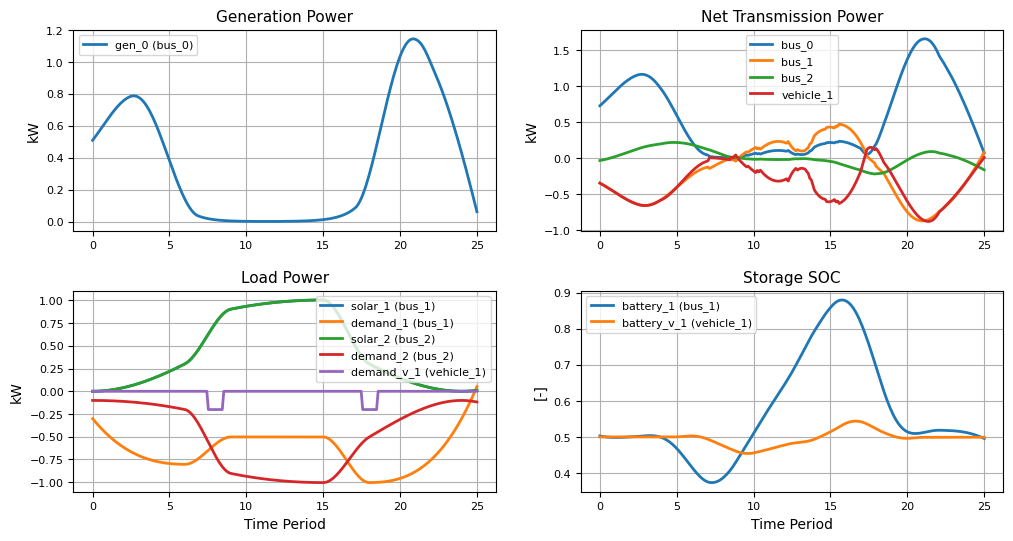

In [5]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
}

fig = src.figures.PlotDashboard(opf.graph, opf.results, opf.time, **kw)
print(opf.results['bus_0']['objects']['gen_0']['cost'].sum())
# fig.savefig('Document/figs/dashboard_0.png', bbox_inches = 'tight')

In [6]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10, 'bounds': (0, np.inf)},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    {'id': 'battery_1', 'type': 'storage','capacity': 5,
     'efficiency': .88, 'charge_limit': np.inf},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -2},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .5, 'final': .5, 'bounds': (.2,.8),
     'efficiency': .88, 'charge_limit': np.inf},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = .9
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = []
vehicle_at_work_limits = []

for idx in range(len(time)):
    if vehicle_at_home[idx] > 0:
        vehicle_at_home_limits.append(two_way)
    else:
        vehicle_at_home_limits.append(unplugged)

    if vehicle_at_work[idx] > 0:
        vehicle_at_work_limits.append(two_way)
    else:
        vehicle_at_work_limits.append(unplugged)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [7]:
deep_reload(src)

opf_1 = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf_1.solve(**solver_kwargs)

917.7299243951


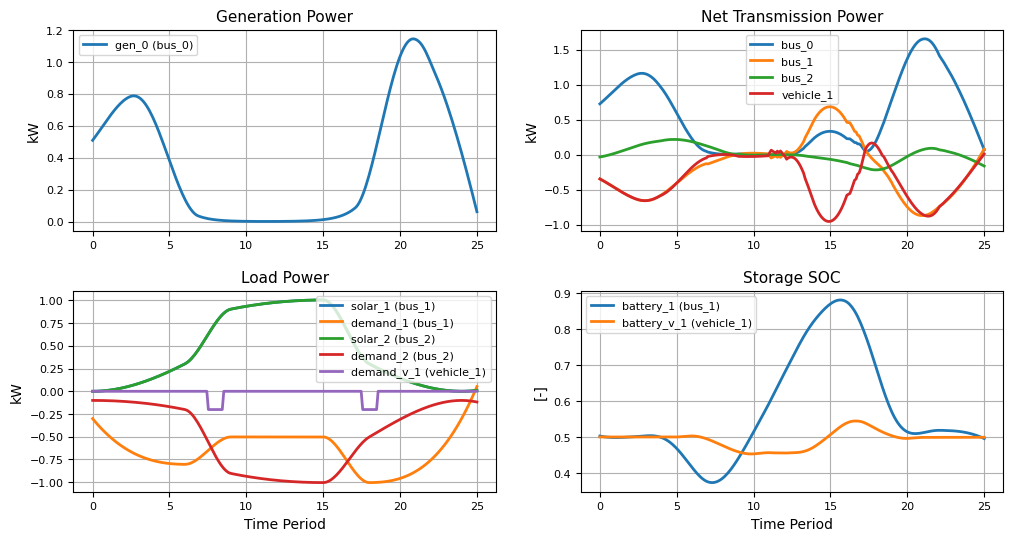

In [8]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
}

fig = src.figures.PlotDashboard(opf_1.graph, opf_1.results, opf_1.time, **kw)
print(opf_1.results['bus_0']['objects']['gen_0']['cost'].sum())
# fig.savefig('Document/figs/dashboard_0.png', bbox_inches = 'tight')

In [9]:
print(opf.results['bus_0']['objects']['gen_0']['cost'].sum(),
opf_1.results['bus_0']['objects']['gen_0']['cost'].sum())

917.7299230666 917.7299243951


In [13]:
# Generating graph - solar + static storage
deep_reload(src)

nodes = []

# Buses
nodes.append({'id': 'bus_0', 'dependents': [
    {'id': 'gen_0', 'type': 'generation', 'cost': 10, 'bounds': (0, np.inf)},
    {'id': 'dis_0', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'bus_1', 'dependents': [
    {'id': 'solar_1', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_1', 'type': 'load', 'value': residential_load_curve * -10},
    {'id': 'dis_1', 'type': 'dissipation'},
    {'id': 'battery_1', 'type': 'storage','capacity': 50,
     'efficiency': .88, 'charge_limit': np.inf},
    ]})

nodes.append({'id': 'bus_2', 'dependents': [
    {'id': 'solar_2', 'type': 'load', 'value': solar_curve * 10},
    {'id': 'demand_2', 'type': 'load', 'value': commercial_load_curve * -10},
    {'id': 'dis_2', 'type': 'dissipation'},
    ]})

nodes.append({'id': 'vehicle_1', 'dependents': [
    {'id': 'demand_v_1', 'type': 'load', 'value': vehicle_load_curve * -2},
    {'id': 'battery_v_1', 'type': 'storage', 'capacity': 5,
     'initial': .5, 'final': .5, 'bounds': (.2,.8),
     'efficiency': .88, 'charge_limit': np.inf},
    {'id': 'dis_v_1', 'type': 'dissipation'},
    ]})

links = []

eff = .9
sus = 1

# Buses to buses
links.append({'source': 'bus_0' ,'target': 'bus_1', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_0' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})
links.append({'source': 'bus_1' ,'target': 'bus_2', 'susceptance': sus, 'efficiency': eff})

unplugged = (0, 0)
one_way = (0, np.inf)
two_way = (-np.inf, np.inf)

vehicle_at_home_limits = []
vehicle_at_work_limits = []

for idx in range(len(time)):
    if vehicle_at_home[idx] > 0:
        vehicle_at_home_limits.append(two_way)
    else:
        vehicle_at_home_limits.append(unplugged)

    if vehicle_at_work[idx] > 0:
        vehicle_at_work_limits.append(two_way)
    else:
        vehicle_at_work_limits.append(unplugged)

links.append({'source': 'bus_1' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_home_limits, 
             })


links.append({'source': 'bus_2' ,'target': 'vehicle_1',
              'susceptance': 1, 'efficiency': .88, 'limit': vehicle_at_work_limits,
             })

nlg = {'nodes': nodes, 'links': links}
graph = src.graph.graph_from_nlg(nlg, directed = True, multigraph = False)

In [14]:
deep_reload(src)

opf_1 = src.optimization.DC_OPF(graph, time)

solver_kwargs={'_name': 'cbc', 'executable': 'src/cbc'}

opf_1.solve(**solver_kwargs)

917.7299243951


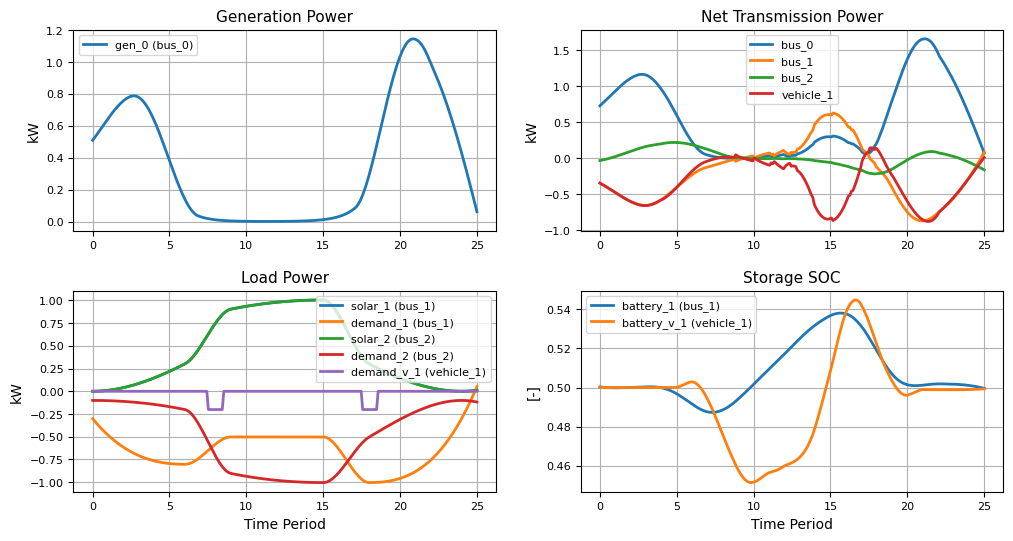

In [15]:
deep_reload(src)

kw = {
    'figure': {
        'figsize': (12,6),
        'gridspec_kw': {
            'hspace': .3,
            'wspace': .2,
        }
    },
    'plot': {
        'linewidth': 2,
    },
    'axes': {
        'facecolor': 'white',
    },
}

fig = src.figures.PlotDashboard(opf_1.graph, opf_1.results, opf_1.time, **kw)
print(opf_1.results['bus_0']['objects']['gen_0']['cost'].sum())
# fig.savefig('Document/figs/dashboard_0.png', bbox_inches = 'tight')